In [1]:
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# if NOT working in colab
data_dir = './data'

# if working in colab
# data_dir = './'

In [3]:
df_skill_type = pd.read_csv(os.path.join(data_dir, 'NOC_skilltype.csv'))
df_major_group = pd.read_csv(os.path.join(data_dir, './NOC_majorgroup.csv'))
df_minor_group = pd.read_csv(os.path.join(data_dir, './NOC_minorgroup.csv'))
df = pd.read_csv(os.path.join(data_dir, './noc_data_get_byws_dealing_slash.csv'))

In [4]:
# pad missing digits from noc codes
df['Noc_code'] = df['Noc_code'].apply(lambda x: '{0:0>4}'.format(x))

# Test for different non-alphanumeric characters, EDA for text cleaning

In [5]:
ocurrences = 0

def find_character(string, char):
    global ocurrences
    for occ in string.split(';'):
        if char in occ:
            ocurrences += 1
        
df['job_title'].apply(find_character, args=('.'))

print(ocurrences)

34


In [95]:
# key is abbreviation, value is expanded occupation
abbreviations_map = {}

def handle_single_quotes(text):
    """
    handle plurals, which are the main use of the single quote. Afterwards, drop all other single quotes
    """
    text = text.replace("s'", '').replace("'s", '')
    return text.replace("'", '')

def handle_parentheses(text, strip_abbrev):
    """
    Parentheses seem to fall into two general cases in the VAST majority of instances:
    1. Indicates an abbreviation
    2. Indicates an exception, by using keywords such as "except" or "non"
    """
    parentheses_idx = 0
    split = text.split("(")
    for i, substr in enumerate(split):
        if ')' in substr:
            parentheses_idx = i
            break
    
    # fragment before the fragment with the paren.
    str1 = split[parentheses_idx-1].strip()
    assert not ')' in str1
    
    # fragment w parenthesis
    str2 = split[parentheses_idx].split(")")[0].strip()
    
    if 'except' in str2 or 'non' in str2:
        text = text.replace(str2, '')
        # TODO, do something with exceptions
        
    else:
        # take the shorter string as the abbreviation
        ab, ex = (str1, str2) if len(str1) < len(str2) else (str2, str1)
    
        # save abbreviation
        abbreviations_map[ab] = ex
        
        # remove the found abbreviation from job title
        if strip_abbrev:
            text = text.replace(ab, '')

    # remove parentheses, leading and trailing whitespace 
    text = text.replace('(','').replace(')','').strip()
    
    return text

def preprocess_text(text, strip_abbrev=False):
    
    # handle slashes
    text = text.replace("/", ' ')
    
    # remove redundant semi-colons
    text = text.strip(';')
    
    # hyphens are semantic noise, remove
    text = text.replace('-', ' ')
    
    # handle '
    if "'" in text:
        text = handle_single_quotes(text)
    
    # handle ,
    text = text.replace(",", '')
    
    # handle .
    text = text.replace(".", '')
    
    # handle parentheses, only one check necessary since we already verified they are all paired with corresponding ')'
    if "(" in text:
        text = handle_parentheses(text, strip_abbrev=strip_abbrev)
    
    # remove leading and trailing whitespace
    text = text.strip()
    
    # normalize case
    return text.lower()

In [96]:
all_job_samples = {}

def extract_job_samples(row):
    NOC_code = int(row['Noc_code'])
    
    # split jobs contained in row by ';' and .replace('-', '; ') is for '-', .replace('-', '; ')
    # REVISE WHETHER TO KEEP - separation. logic is that lieutenant-governor can be described as lieutenant governer, no hyphen
    # make unique set
    # strip extra characters 
    # and take nonempty elements
    jobs = [
        j for j in  row['job_title'].split(';')
        if (j != '' and j != ' ')
    ]
    
    # change gendered entries such as 'chairman/woman' into separate samples, 'chairman', 'chairwoman'
    for idx, job in enumerate(jobs):
        if 'man/woman' in job:
            # change original entry to 'job(man)', then append job(woman) to end of list
            jobs[idx] = job.replace('man/woman', 'man')
            jobs.append(job.replace('man/woman', 'woman'))
        if 'men/women' in job:
            jobs[idx] = job.replace('men/women', 'men')
            jobs.append(job.replace('men/women', 'women'))
        if 'boy/girl' in job:
            jobs[idx] = job.replace('boy/girl', 'boy')
            jobs.append(job.replace('boy/girl', 'girl'))
        if 'master/mistress' in job:
            jobs[idx] = job.replace('master/mistress', 'master')
            jobs.append(job.replace('master/mistress', 'mistress'))
        if 'host/hostess' in job:
            jobs[idx] = job.replace('host/hostess', 'host')
            jobs.append(job.replace('host/hostess', 'hostess'))
        if 'waiter/waitress' in job:
            jobs[idx] = job.replace('waiter/waitress', 'waiter')
            jobs.append(job.replace('waiter/waitress', 'waitress'))
        
    # clean text data
    preprocessed_jobs = [preprocess_text(job) for job in jobs]
            
    # remove duplicate entries
    preprocessed_jobs = set(preprocessed_jobs)
    
    # parse counts of each job
    row['n_sample_jobs'] = len(preprocessed_jobs)
    
    # iterate through job and add to dictionary
    for j in preprocessed_jobs:
        
        if j not in all_job_samples:
            all_job_samples[j] = NOC_code

        # safe check, if job appears more than once, clause will print the both NOC Codes
        else:
            if all_job_samples[j] != NOC_code:
                print(j, 'repeated', all_job_samples[j], NOC_code)
    
    return row

def parse_1(row):
    # get info from first digit of 4 digit code
    row['1_digit_target'] = int(str(row['Noc_code'])[0])
    row['1_digit_group'] = df_skill_type[df_skill_type['skilltype_code'] == row['1_digit_target']]['skilltype_title']
        
    return row

def parse_2(row):
    # get info from first 2 digits of 4 digit code
    
    # check if NOC code is long enough for parsing
    if len(str(row['Noc_code'])) > 1:
        row['2_digit_target'] = int(str(row['Noc_code'])[:2])
        row['2_digit_group'] = df_major_group[df_major_group['majorgroup_code'] == '\'' + str(row['2_digit_target'])]['majorgroup_title']
        
    else:
        row['2_digit_target'] = 'NA'
        row['2_digit_group'] = 'NA'
    
    return row

def parse_3(row):
    # get info from first 3 digits of 4 digit code
    
    # check if NOC code is long enough for parsing
    if len(str(row['Noc_code'])) > 2:
        row['3_digit_target'] = int(str(row['Noc_code'])[:3])
        row['3_digit_group'] = df_minor_group[df_minor_group['minorgroup_code'] == '\'' + str(row['3_digit_target'])]['minorgroup_title']
        
    else:
        row['3_digit_target'] = 'NA'
        row['3_digit_group'] = 'NA'
        
    return row

In [97]:
# Do once, if 'noc_code' column already dropped, except to skip action
try:
    df = df.apply(parse_1, axis = 1)
    df = df.apply(parse_2, axis = 1)
    df = df.apply(parse_3, axis = 1)
    df = df.apply(extract_job_samples, axis = 1)
except KeyError:
    pass

len(all_job_samples.keys())

29518

In [45]:
all_descriptions = {}
desc_counts = []
def unpack_descriptions(row):
    # unpack all descriptions from a row and
    duty = row['main_duties']
    desc_counts.append(0)
    
    # split duty field into separate duties and remove initial generic blurb
    for description in duty.strip('-').split(';'):
        if 'duties' not in description:
            all_descriptions[description] = row['Noc_code']
            desc_counts[-1] += 1
            
    return row

df = df.apply(unpack_descriptions, axis = 1)

# Make dictionary from selected data

In [46]:
train_df = dict(all_job_samples)
# train_df.update(all_descriptions)
train_df = pd.DataFrame(train_df.items(), columns = ['input', 'code'])
train_df['input'] = train_df['input'].apply(preprocess_text)

# Grab sample to see if preprocessing worked

In [47]:
def check(string):
    try:
        assert '.' not in string \
            and ',' not in string \
                and ')' not in string \
                    and '(' not in string \
                        and '-' not in string \
                            and ';' not in string \
                                and '/' not in string \
                                    and '\'' not in string
    except AssertionError:
        print(string)

In [54]:
train_df['input'].apply(check)
display(train_df.sample(20))

,input,code
508,investment manager financial brokerage,121
22611,disc flanging operator metal fabrication,9416
522,financial brokerage manager,121
7173,medical missionary,3112
1303,homemaker services director social services,423
12063,laundry and dry cleaning foreman,6316
13453,room flipper,6721
15039,facilities wirer telecommunications,7246
11648,roller skating instructor,5254
21371,rotary furnace tender chemical processing,9232


In [55]:
def first_n_digits(string, n=4):
    
    # if default number of digits desired, don't do anything
    if n == 4:
        return string
    
    # else pad left with zeros until 4 digits reached
    padded_str = '{0:0>4}'.format(string)
    return padded_str[:n]

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
 
X = train_df['input']

y1 = train_df['code'].apply(first_n_digits, args = (1,)).astype('int')
y2 = train_df['code'].apply(first_n_digits, args = (2,)).astype('int')
y3 = train_df['code'].apply(first_n_digits, args = (3,)).astype('int')
y4 = train_df['code'].apply(first_n_digits, args = (4,)).astype('int')

# select how many digits to train on
y = y4

X_train, y_train = X, y

corpus = list(X_train)

# For window size calculation, get mean length of input

In [59]:
np.mean([len(x.split()) for x in X_train])

3.511717953943346

## Start Doc2vec code

In [60]:
#Import all the dependencies
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import nltk
from tqdm import tqdm
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\augus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [61]:
tagged_data = [TaggedDocument(words=word_tokenize(item.lower()), tags=[str(i)]) for i, item in enumerate(corpus)]

In [111]:
TRIAL_NAME = 'trial_9'
curr_model_name = "{}.model".format(TRIAL_NAME)

epochs = 4096 # training cycles
vec_size = 32 # specific to doc2vec, size of the output vector
alpha = 0.001 # learning rate
window = 3
min_count = 2
min_alpha = 0.00025

try:
    assert not os.path.exists(curr_model_name), "Model {} already exists! Update model output name".format(curr_model_name)


    model = Doc2Vec(vector_size=vec_size,
                    alpha=alpha, 
                    window=window,
                    min_alpha=min_alpha,
                    min_count= min_count,
                    dm=1)

    model.build_vocab(tagged_data)

    for epoch in tqdm(range(epochs)):
        model.train(tagged_data,
                    total_examples=model.corpus_count,
                    epochs=model.epochs)
        # LR scheduling
        model.alpha -= 0.00002

    model.save(curr_model_name)
    print("Model {} Saved".format(curr_model_name))

except AssertionError:
    print("Existing Model {} Found".format(curr_model_name))

Existing Model trial_9.model Found


In [112]:
from gensim.models.doc2vec import Doc2Vec
from nltk.tokenize.treebank import TreebankWordDetokenizer
detokenizer = TreebankWordDetokenizer()

model= Doc2Vec.load(curr_model_name)

In [113]:
from collections import Counter

def get_doc2vec_encoding(occ, steps=128, alpha=0.03):
    test_data = word_tokenize(occ)
    test_vector = model.infer_vector(test_data, steps=steps, alpha=alpha)
    return test_vector

def get_occ_and_code_from_tokens(training_doc):
    """
    Return the train input in readable form as well as its corresponding NOC code
    """
    tokens = tagged_data[int(training_doc[0])][0]
    
    detokenized_job = detokenizer.detokenize(tokens)
        
    try:
        code = int(train_df[train_df['input'] == detokenized_job]['code'])
    except TypeError:
        try: # TEMPORARY WHILE WE FIX PARENTHESES PROBLEM
            code = int(
                train_df.loc[train_df['input'].str.contains(detokenized_job.split('(')[0]), 'code'].values[0]
            )
        except ValueError:
            code = 0
        except IndexError:
            code = 0
    
    return detokenized_job, code

def infer(str_input, verbose=False):
    
    preprocessed_str = preprocess_text(str_input)
    
    job_vector = get_doc2vec_encoding(preprocessed_str)
    
    # to find most similar doc using tags
    similar_doc = model.docvecs.most_similar([job_vector])
    
    codes = []
    
    if verbose:
        print('---------Test on {}---------'.format(preprocessed_str))
    
    for doc in similar_doc:
        
        job, code = get_occ_and_code_from_tokens(doc)
                
        codes.append(code)
        
        if verbose:
            print('{} - {}'.format(job, code))
    
    return Counter(codes)

def process_counter(counter):
    
    if len(counter) >= 3:
        v1, v2, v3 = (int(w) for w, c in counter.most_common(3))
        
    elif len(counter) == 2:
        v1, v2  = (int(w) for w, c in counter.most_common(2))
        v3 = 0
        
    elif len(counter) == 1:
        v1 = counter.most_common(1)[0][0]
        v2, v3 = 0, 0
            
    return pd.Series([v1, v2, v3])

def infer_and_vote(occ, verbose=False):
    counter = infer(occ, verbose=verbose)
    return process_counter(counter)

In [114]:
test_occupations = ['doctor', 'athlete', 'member of parliament',
                    'teacher', 'researcher', 'registered nurse', 
                    'CUSTOMER SERVICE', 'MANAGER OF CLEANING BUSINESS',
                   'CAREGIVER', 'Farm Boss']

for occ in test_occupations: 
    print(infer_and_vote(occ, verbose=True))
    

---------Test on doctor---------
locum doctor - 3112
osteopathic doctor - 3125
medical doctor - 3112
chinese medicine doctor - 3232
saw doctor - 7384
naturopathic doctor - 3125
chiropractic doctor - 3122
missionary doctor - 3112
doctor office receptionist - 1414
doctor office nurse - 3012
0    3112
1    3125
2    3232
dtype: int64
---------Test on athlete---------
athlete - 5251
circus artist - 5232
author - 5121
amateur athlete - 5251
theatrical business agent - 1123
flat knitter - 9442
artistic floral designer - 5244
humorist author - 5121
link machine knitter - 9442
artistic bouquet designer - 5244
0    5251
1    5121
2    9442
dtype: int64
---------Test on member of parliament---------
fishing vessel boun - 8261
human resources assistant - 1415
fishing vessel checkerman - 8441
fishing vessel checkerwoman - 8441
fishing vessel skiffman - 8441
fishing vessel skiffwoman - 8441
fishing vessel netmender - 8441
executive housekeeper - 6312
fishing vessel captain - 8261
human resources cl

# Apply embeddings to training data

In [69]:
train_d2v_embeddings = train_df['input'].apply(get_doc2vec_encoding)

In [70]:
def vectorize_embeddings(data):
    return np.array([list(x) for x in np.array(data)])

In [71]:
train_df['doc2vec_embeddings'] = train_d2v_embeddings

In [74]:
TARGET_CODE_LENGTH = 4

classifier_input = vectorize_embeddings(train_d2v_embeddings)
classifer_output = np.array(train_df['code'].apply(first_n_digits, args = (TARGET_CODE_LENGTH,)))

# Build preliminary classifiers

In [75]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [80]:
import time

12.000398
-17.926199


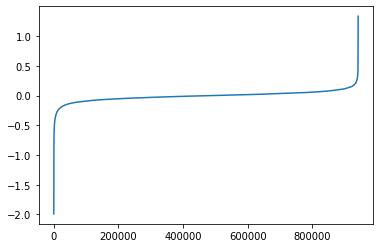

In [79]:
plt.plot(sorted(np.divide(classifier_input, 9).flatten()))
print(max(classifier_input.flatten()))
print(min(classifier_input.flatten()))

In [86]:
SVM = SVC(class_weight='balanced', kernel='linear')

start = time.time()
SVM.fit(classifier_input, classifer_output)
print('SVM training duration: {} seconds'.format(time.time()-start))

SVM training duration: 40.18838810920715 seconds


In [87]:
RF = RandomForestClassifier(n_estimators=256, max_depth=128, n_jobs=-1, warm_start=True)

start = time.time()
RF.fit(classifier_input, classifer_output)
print('RF training duration: {} seconds'.format(time.time()-start))

RF training duration: 153.7318708896637 seconds


In [82]:
KNN = KNeighborsClassifier(n_neighbors = 1, n_jobs=-1)

start = time.time()
KNN.fit(classifier_input, classifer_output)
print('KNN training duration: {} seconds'.format(time.time()-start))

KNN training duration: 0.2558553218841553 seconds


# Load Test data

In [76]:
ATP_data = pd.DataFrame(pd.read_excel('./Data/V5_Run Input(1).xlsx'))

In [77]:
trimmed_ATP = ATP_data
trimmed_ATP['Current Job Title'] = trimmed_ATP['Current Job Title'].apply(preprocess_text)
trimmed_ATP['Current Industry'] = trimmed_ATP['Current Industry'].apply(preprocess_text)
trimmed_ATP['NOC code'] = trimmed_ATP['NOC code '].apply(lambda x: int(x.strip('\''))).apply(first_n_digits, args=(TARGET_CODE_LENGTH,))
trimmed_ATP.drop(columns = ['NOC code '], inplace = True)

In [78]:
trimmed_ATP['vote1'], trimmed_ATP['vote2'], trimmed_ATP['vote3'] = None, None, None
trimmed_ATP[['vote1', 'vote2' ,'vote3']] = trimmed_ATP['Current Job Title'].apply(infer_and_vote)
TPs = trimmed_ATP.apply(lambda row: int(row['NOC code']) in [row['vote1'], row['vote2'], row['vote3']], axis = 1)

In [81]:
TPs.value_counts()

False    23726
True     16298
dtype: int64

In [84]:
test_d2v_embeddings = trimmed_ATP['Current Job Title'].apply(get_doc2vec_encoding)
trimmed_ATP['doc2vec_embeddings'] = test_d2v_embeddings

In [85]:
vectorized_embeddings = vectorize_embeddings(test_d2v_embeddings)

In [88]:
trimmed_ATP['rf_pred'] = RF.predict(vectorized_embeddings)

In [89]:
trimmed_ATP['knn_pred'] = KNN.predict(vectorized_embeddings)

In [90]:
trimmed_ATP['svm_pred'] = SVM.predict(vectorized_embeddings)

In [91]:
trimmed_ATP[['knn_pred', 'svm_pred', 'rf_pred', 'NOC code']]

,knn_pred,svm_pred,rf_pred,NOC code
0,11,4154,11,11
1,124,212,4021,11
2,4212,12,1221,11
3,1121,422,1121,11
4,11,3236,11,11
...,...,...,...,...
40019,8252,8221,6513,821
40020,6421,6513,6421,6221
40021,1112,9536,1112,811
40022,3216,8252,7302,4423


In [92]:
from sklearn.metrics import accuracy_score, f1_score

for classifier in ['knn','svm', 'rf']:
    print('{} acc:{}, f1-macro:{}'.format(classifier.upper(), 
                                    accuracy_score(
                                        trimmed_ATP['{}_pred'.format(classifier)], 
                                        trimmed_ATP['NOC code']
                                    ),
                                    f1_score(
                                        trimmed_ATP['{}_pred'.format(classifier)],
                                        trimmed_ATP['NOC code'], average = 'macro')
                                   )
     )

KNN acc:0.35608634819108537, f1-macro:0.2246208258228614
SVM acc:0.2453527883270038, f1-macro:0.1687395052553597
RF acc:0.3016939836098341, f1-macro:0.2111054771740159


In [ ]:
# svm accuracy still tanks, potentially overfitting. the problem is too many output classes. 
# to mitigate, build hierarchical model